Train Neural Networks to estimate Likelihood Ratios
===

In this notebook we will setup the neural networks that train unbiased and low-variance density ratios to be then used for inference. The statistical model we have is: 

$$p(x|\mu, \alpha) = \frac{1}{\nu(\mu, \alpha)} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot p_c\left(x|\alpha\right)$$ 

In [2]:
import os, sys, importlib
sys.path.append('../')

import common_utils
from common_utils import plotting, training
from common_utils.training import TrainEvaluate_NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
hep.style.use(hep.style.ATLAS)


/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:10: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-02-10 11:00:14.840943: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-10 11:00:15.717168: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Load the datasets from pre-processed input
saved_data='./cached_data/'

training_features = np.load(f"{saved_data}features.npy")
train_labels = np.load(f"{saved_data}train_labels.npy")
preselection_score = np.load(f"{saved_data}preselection_score.npy")
weights = np.load(f"{saved_data}weights.npy")

In [4]:
# labels_dict = {"ttbar": 0,
#                "single_top_s_chan":1,
#               "single_top_t_chan":2,
#               "single_top_tW":3,
#               "wjets":4}

# Keep only a subset of the background for illustration
labels_dict = {"ttbar": 0,
              "single_top_t_chan":1,
              "wjets":2}

In [5]:
min_pred = np.amin(preselection_score)
max_pred = np.amax(preselection_score)

bins = np.linspace(min_pred, max_pred, num=150)

hist_NN_output = {}

for key in labels_dict: 
    hist_NN_output[key], _ = np.histogram(preselection_score[train_labels==labels_dict[key]], weights = weights[train_labels==labels_dict[key]], bins=bins)


Make a selection cut for performing the NSBI analysis, balancing the number of signal events that go into the signal region (increasing sensitivity) and the feasibility of training accurate and precise NNs over a large phase space (need bigger models and more statistics).

As a first cut, we choose a loose preselection and see if it works.

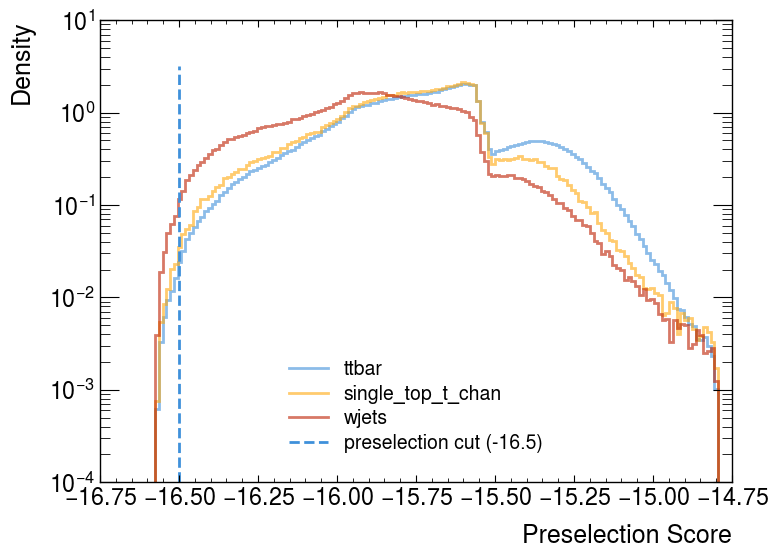

In [6]:
preselection_cut = -16.5 # Lets start with a very loose cut

for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins=bins, 
             alpha=0.6, label=key, 
             density=True, linewidth=2.0)

plt.xlabel("Preselection Score", size=18)
plt.axvline(preselection_cut, ymax=0.9, linestyle='--', label=f'preselection cut ({preselection_cut})')
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

In [7]:
# Make the preselections

training_features = training_features[preselection_score>=preselection_cut].copy()
train_labels = train_labels[preselection_score>=preselection_cut].copy()
weights = weights[preselection_score>=preselection_cut].copy()

preselection_score_selected = preselection_score[preselection_score>=preselection_cut].copy()


In [8]:
type_vec = np.array(train_labels, dtype='object')

for key in labels_dict:
    type_vec[type_vec==labels_dict[key]] = key


In [9]:
# Build a pandas dataframe from the arrays for density ratio training and validation
columns = ['lepton_pt', 'lepton_eta', 'lepton_phi']
dataset = pd.DataFrame(training_features, columns=columns)

dataset['log_lepton_pt'] = np.log(dataset['lepton_pt'].ravel())

dataset['presel_score'] = preselection_score_selected
dataset['train_labels'] = train_labels
dataset['type'] = type_vec
dataset['weights'] = weights

In [10]:
# Normalizing the training weights - only discriminating shapes, not norms

weights_normed = weights.copy()

for key in labels_dict:

    weights_normed[train_labels==labels_dict[key]] /= weights[train_labels==labels_dict[key]].sum()

dataset['weights_normed'] = weights_normed


In [11]:
# Save the preselected dataframe for inference use later on
dataset.to_hdf(f"{saved_data}dataset_preselected_ttbar.h5", key="dataset", mode='w')


In [12]:
columns = ['lepton_pt', 'lepton_eta', 'lepton_phi']
columns_scaling = ['lepton_pt', 'lepton_eta', 'lepton_phi']

columns = ['log_lepton_pt', 'lepton_eta', 'lepton_phi']
columns_scaling = ['log_lepton_pt', 'lepton_eta', 'lepton_phi']

In [13]:
# Choose ttbar as the reference hypothesis
dataset_ch_wjets_ref = pd.concat([dataset[dataset['type']=='wjets'], 
                                  dataset[dataset['type']=='ttbar']])

dataset_ch_wjets_ref['train_labels'] = 0
dataset_ch_wjets_ref.loc[dataset_ch_wjets_ref['type']=='ttbar', 'train_labels'] = 1


In [14]:

rnd_seed_traintestsplit = 42
channel_names = ['wjets', 'ttbar']

# Save paths
output_dir = './output_general_wjets/'
output_name = 'first_training_wjets'
path_to_ratios = './output_ratios_wjets/'
path_to_figures = './output_figures_wjets/'
path_to_models = './output_model_params_wjets/'

importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN

# Initialize the training class
NN_training = TrainEvaluate_NN(dataset_ch_wjets_ref, 
                               dataset_ch_wjets_ref['weights_normed'],
                               dataset_ch_wjets_ref['train_labels'],
                               columns, 
                               columns_scaling, rnd_seed_traintestsplit, 
                               channel_names, output_dir, output_name, 
                                path_to_figures=path_to_figures,
                                path_to_ratios=path_to_ratios, 
                                path_to_models=path_to_models)



In [ ]:
# Train the density ratio NN
NN_training.train(hidden_layers=2, 
                        neurons=1000, 
                        number_of_epochs=70, 
                        batch_size=512, 
                        learning_rate=0.1, 
                        scalerType='MinMax', 
                        calibration=False, 
                        num_bins_cal = 10, 
                        callback=True, 
                        callback_patience=30, 
                        callback_factor=0.01)    


Sum of weights of class 0: 0.8000007526266657
Sum of weights of class 1: 0.7999985571390978
Using swish activation function
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              4000      
                                                                 
 dense_1 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_2 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 1006001 (3.84 MB)
Trainable params: 1006001 (3.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Using Callbacks
Epoch 1/70
4353/4353 - 121s - loss: 4.3075e-07 - binary_accuracy: 0.5856 - val_loss: 4.1840e-07 - val_binary_accuracy: 0.6254 - lr: 0.1000 - 1

In [ ]:
NN_training.make_overfit_plots()

In [ ]:
num_bins_cal = 50
NN_training.make_calib_plots(nbins=num_bins_cal, observable='score')

In [ ]:
NN_training.make_calib_plots(nbins=num_bins_cal, observable='llr')


In [ ]:
variables_to_plot=['lepton_pt', 'lepton_phi', 'lepton_eta']
yscale_type='log'
num_bins_plotting=21

NN_training.make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [ ]:
NN_training.evaluate_and_save_ratios(dataset)


In [55]:
# Choose ttbar as the reference hypothesis
dataset_ch_single_top_t_chan_ref = pd.concat([dataset[dataset['type']=='single_top_t_chan'], 
                                  dataset[dataset['type']=='ttbar']])

dataset_ch_single_top_t_chan_ref['train_labels'] = 0
dataset_ch_single_top_t_chan_ref.loc[dataset_ch_single_top_t_chan_ref['type']=='ttbar', 'train_labels'] = 1


In [77]:

rnd_seed_traintestsplit = 42
channel_names = ['single_top_t_chan', 'ttbar']

# Save paths
output_dir = './output_general_singletop/'
output_name = 'first_training_singletop'
path_to_ratios = './output_ratios_singletop/'
path_to_figures = './output_figures_singletop/'
path_to_models = './output_model_params_singletop/'



importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN

# Initialize the training class
NN_training = TrainEvaluate_NN(dataset_ch_single_top_t_chan_ref, 
                               dataset_ch_single_top_t_chan_ref['weights_normed'],
                               dataset_ch_single_top_t_chan_ref['train_labels'],
                               columns, 
                               columns_scaling, rnd_seed_traintestsplit, 
                               channel_names, output_dir, output_name, 
                                path_to_figures=path_to_figures,
                                path_to_ratios=path_to_ratios, 
                                path_to_models=path_to_models)



Sum of weights of class 0: 0.8
Sum of weights of class 1: 0.7999986595597879
Using swish activation function
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 1000)              4000      
                                                                 
 dense_54 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_55 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 1006001 (3.84 MB)
Trainable params: 1006001 (3.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Using Callbacks
Epoch 1/50
4219/4219 - 81s - loss: 4.5849e-07 - binary_accuracy: 0.5369 - val_loss: 4.5711e-07 - val_binary_accuracy: 0.5410 - lr: 0.1000 - 81s/epoch - 19

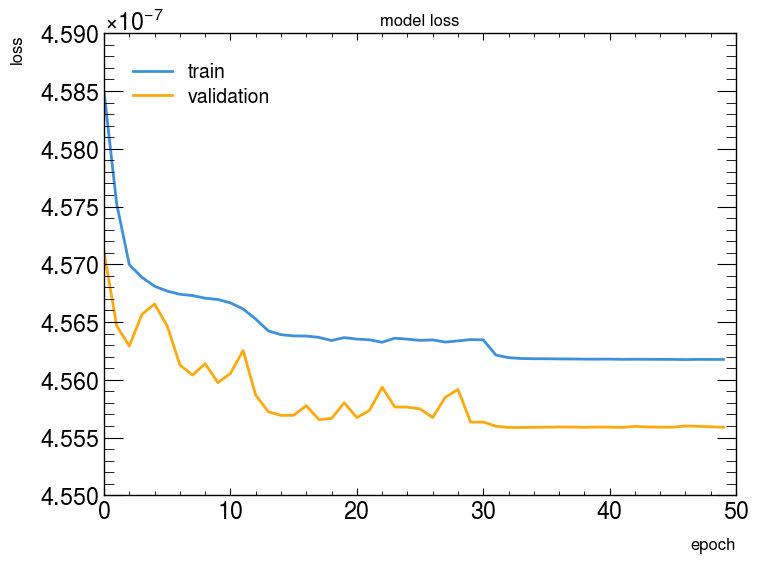

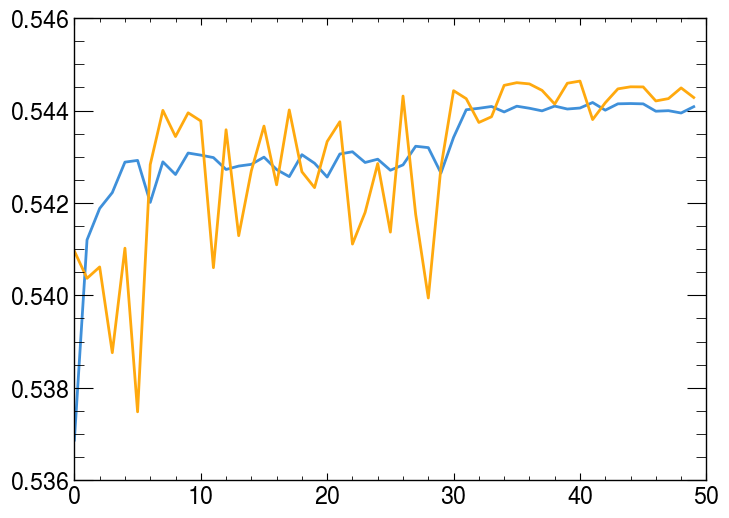

2725/2725 - 2s - 2s/epoch - 734us/step
16025/16025 - 12s - 12s/epoch - 722us/step
10898/10898 - 8s - 8s/epoch - 731us/step
64098/64098 - 48s - 48s/epoch - 748us/step
ttbar training data prediction (max) = 0.80268824
ttbar training data prediction (min) = 0.19852492
single_top_t_chan training data prediction (max) = 0.80304486
single_top_t_chan training data prediction (min) = 0.160852
ttbar training data prediction (max) = 0.8013706
ttbar training data prediction (min) = 0.17381883
single_top_t_chan training data prediction (max) = 0.8030815
single_top_t_chan training data prediction (min) = 0.14754705


<Figure size 800x600 with 0 Axes>

In [82]:
# Train the density ratio NN
NN_training.train(hidden_layers=2, 
                        neurons=1000, 
                        number_of_epochs=50, 
                        batch_size=512, 
                        learning_rate=0.1, 
                        scalerType='MinMax', 
                        calibration=False, 
                        num_bins_cal = 10, 
                        callback=True, 
                        callback_patience=30, 
                        callback_factor=0.01)    


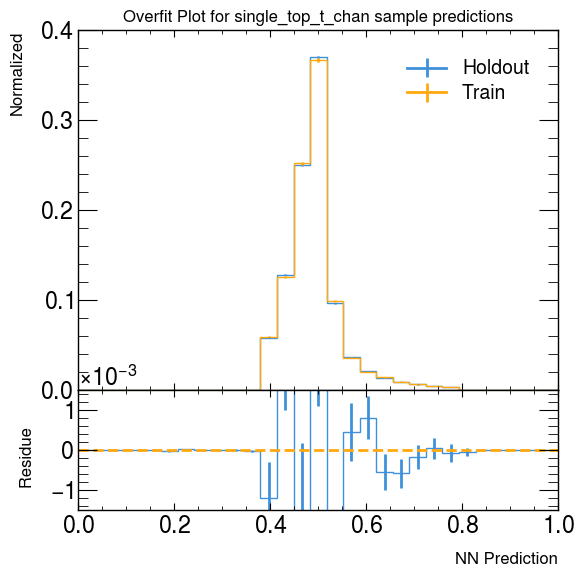

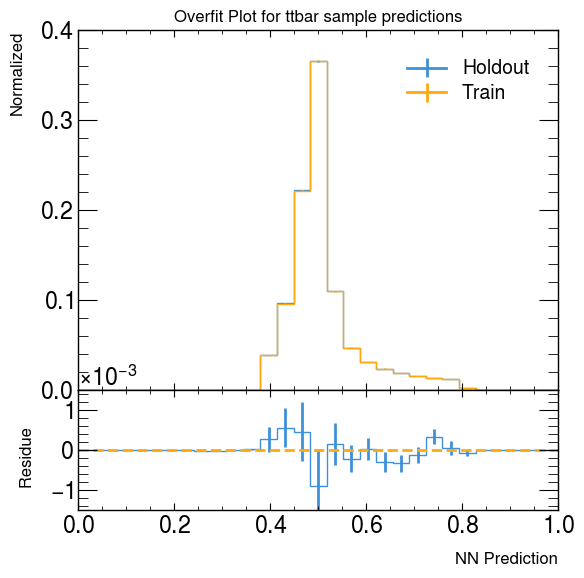

<Figure size 800x600 with 0 Axes>

In [83]:
NN_training.make_overfit_plots()

/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:79: RuntimeWarning: invalid value encountered in divide
  hist_ratio = hist_num/(hist_den+hist_num)
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:82: RuntimeWarning: invalid value encountered in divide
  err = hist_ratio**2 * np.abs(hist_den/hist_num) * np.sqrt((hist_num_err/(hist_num)**2)\
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:83: RuntimeWarning: invalid value encountered in divide
  +(hist_den_err/(hist_den)**2))
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:91: RuntimeWarning: invalid value encountered in divide
  hist_ratio_holdout = hist_num_holdout / ( hist_den_holdout + hist_num_holdout )
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:93: RuntimeWarning: invalid value encountered in divide
  err_holdout = hist_

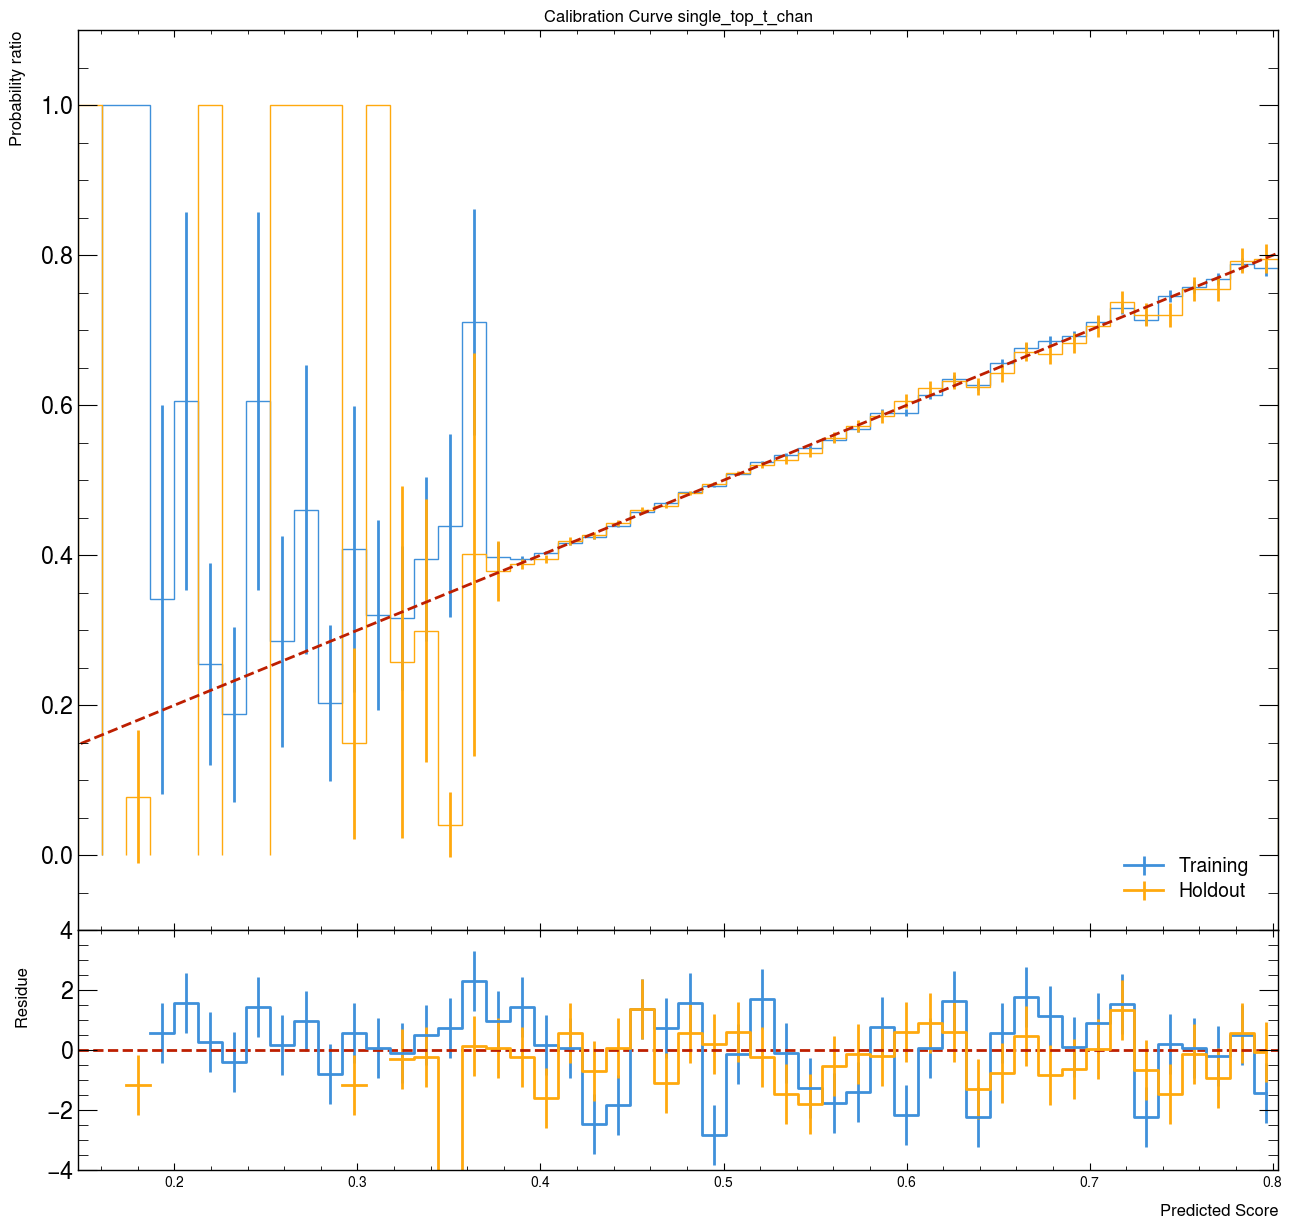

observable not recognized


<Figure size 800x600 with 0 Axes>

In [84]:
num_bins_cal = 50
NN_training.make_calib_plots(nbins=num_bins_cal, observable='score')

/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:156: RuntimeWarning: divide by zero encountered in divide
  h_log = np.log(hist_num/hist_den)
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:156: RuntimeWarning: invalid value encountered in divide
  h_log = np.log(hist_num/hist_den)
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:157: RuntimeWarning: invalid value encountered in divide
  h_log_err = np.sqrt((hist_num_err/hist_num**2)+(hist_den_err/hist_den**2))
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:162: RuntimeWarning: divide by zero encountered in divide
  h_log_holdout = np.log(hist_num_holdout/hist_den_holdout)
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:162: RuntimeWarning: invalid value encountered in divide
  h_log_holdout = np.log(hist_num_holdout/hist_den_hol

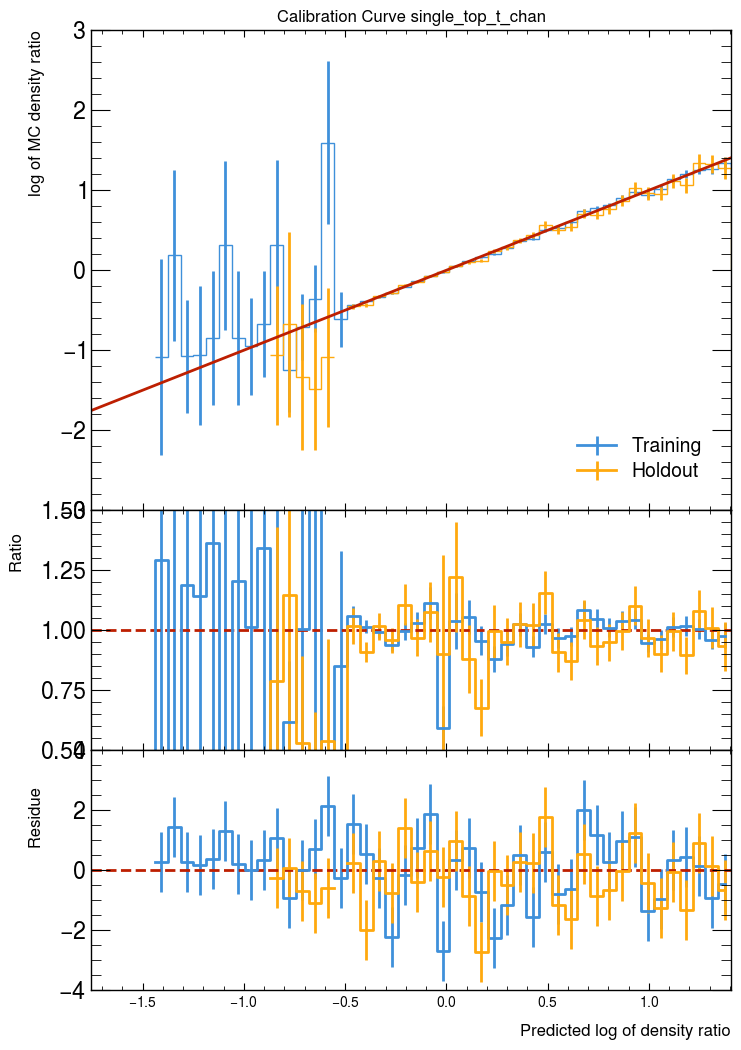

<Figure size 800x600 with 0 Axes>

In [85]:
NN_training.make_calib_plots(nbins=num_bins_cal, observable='llr')


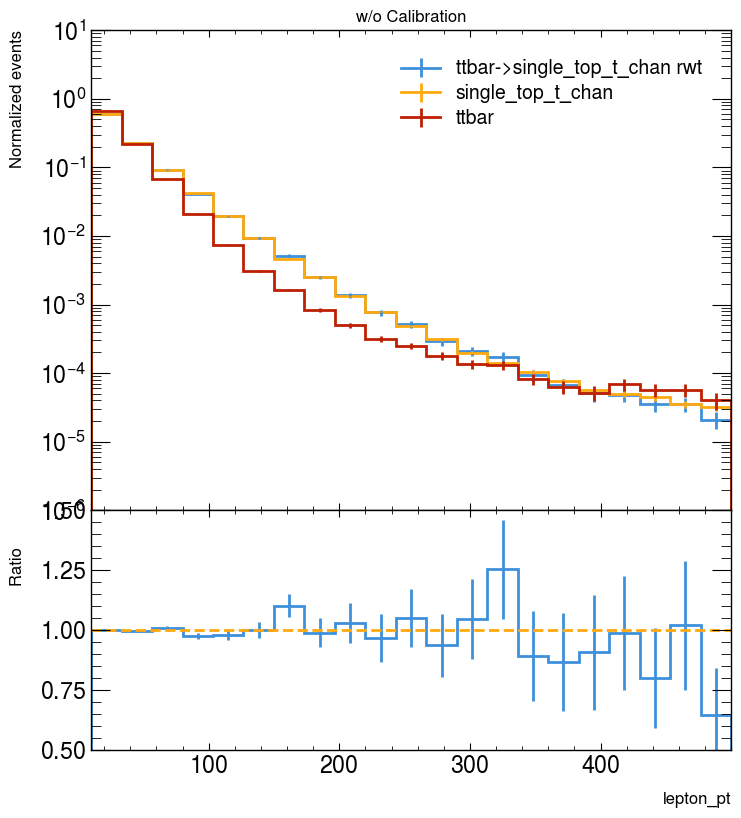

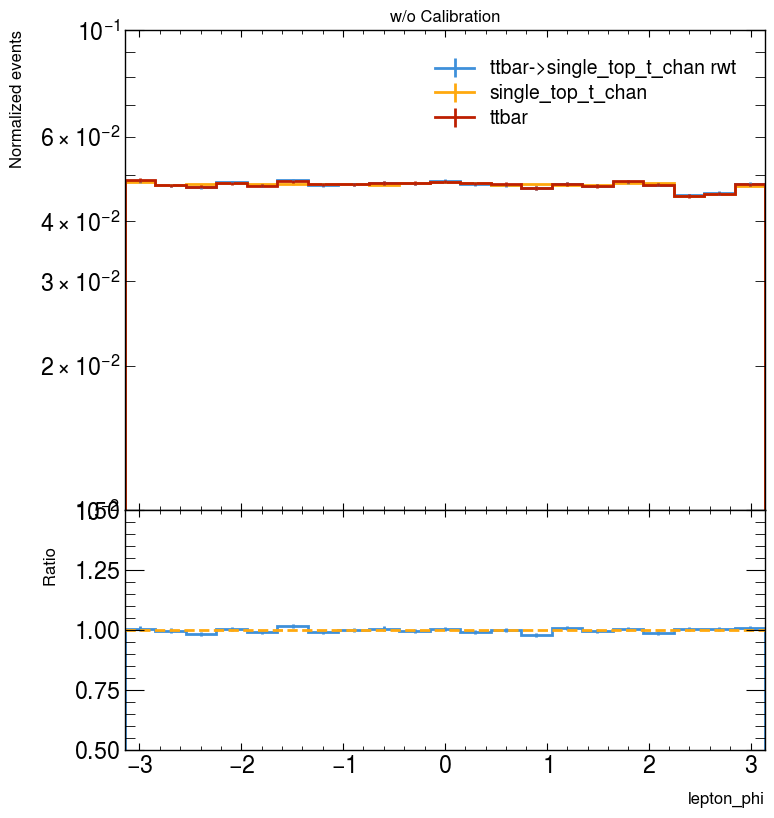

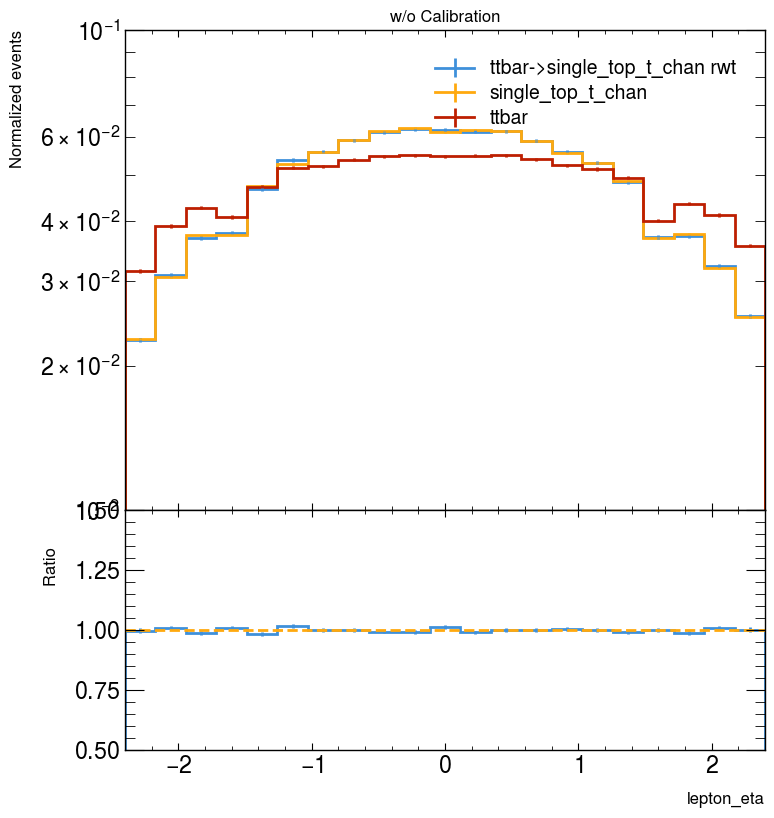

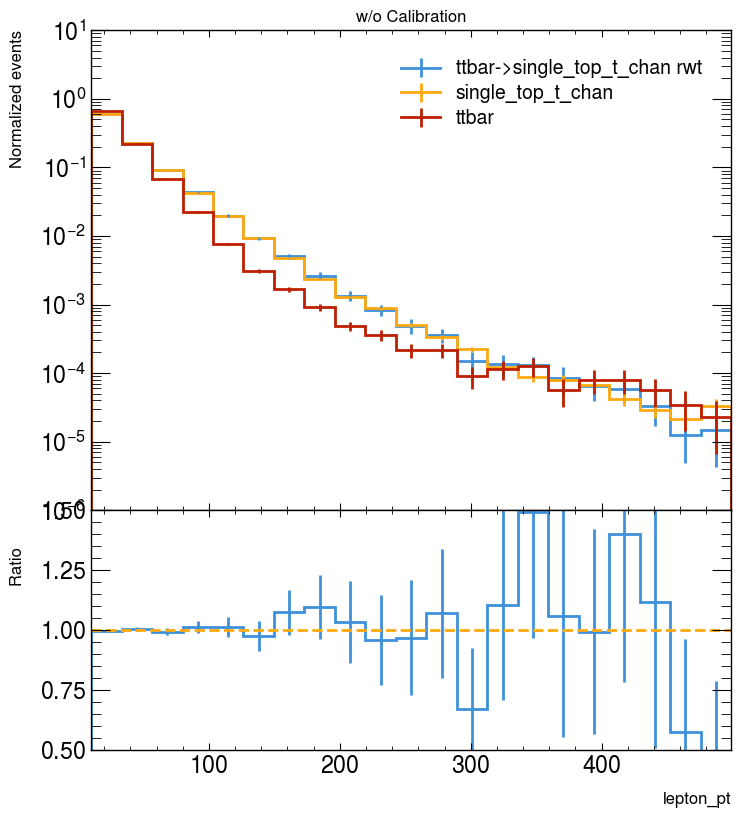

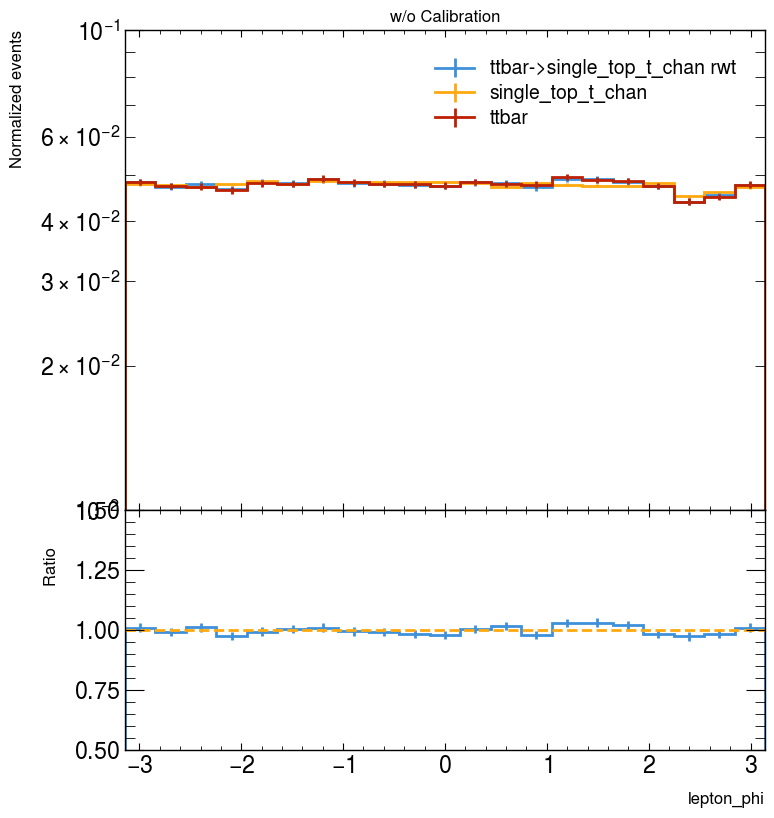

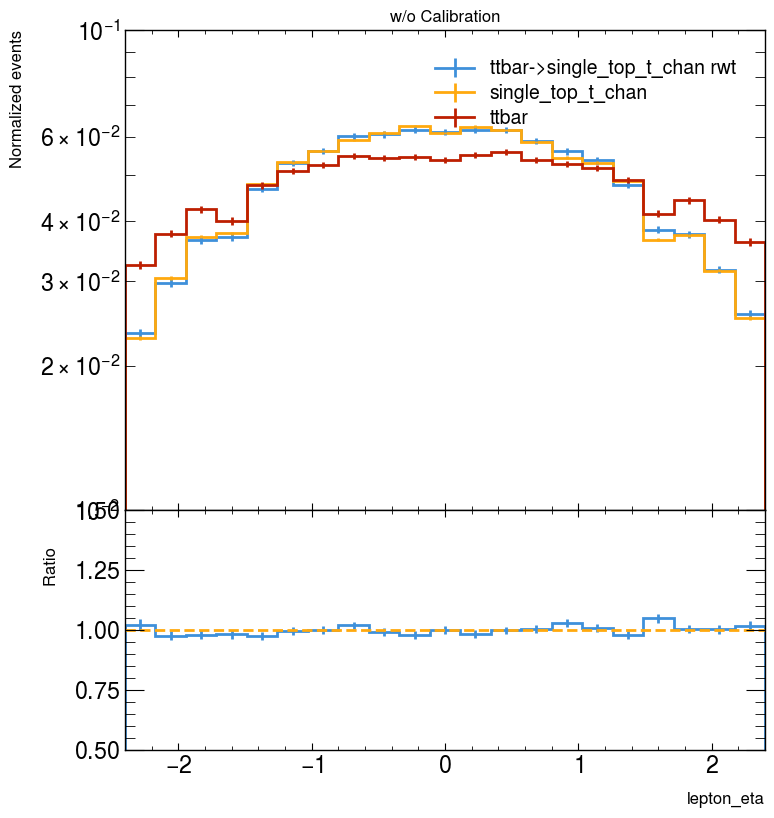

<Figure size 800x600 with 0 Axes>

In [86]:
variables_to_plot=['lepton_pt', 'lepton_phi', 'lepton_eta']
yscale_type='log'
num_bins_plotting=21

NN_training.make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [87]:
importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN
import types

NN_training.make_reweighted_plots = types.MethodType(TrainEvaluate_NN.make_reweighted_plots, NN_training)
NN_training.make_calib_plots = types.MethodType(TrainEvaluate_NN.make_calib_plots, NN_training)
NN_training.evaluate_and_save_ratios = types.MethodType(TrainEvaluate_NN.evaluate_and_save_ratios, NN_training)


In [88]:
NN_training.evaluate_and_save_ratios(dataset)


110353/110353 - 83s - 83s/epoch - 748us/step
